# Homework 2: Text Classification
## Due Date: (TBD)
## Total Points: (TBD)
- **Overview**: For this assignment, we’ll be building a text classifier. The goal of our text classifer will be to distinguish between words that are simple and words that are complex. Example simple words are `heard`, `sat`, and `town`, and example complex words are `abdicate`, `detained`, and `vintners`. Distinguishing between simple and complex words is the first step in a larger NLP task called text simplification, which aims to replace complex words with simpler synonyms. Text simplification is potentially useful for re-writing texts so that they can be more easily understood by younger readers, people learning English as a second language, or people with learning disabilities.

- **Learning goals**:
    - Understand an important class of NLP evaluation methods (precision, recall and F1), and implement them yourself.
    - Employ common experimental design practices in NLP. Split the annotated data into training/development/test sets, implement simple baselines to determine how difficult the task is, and experiment with a range of features and models.
    - Get an introduction to `sklearn`, an excellent machine learning Python package.

- **Data**: We will provide you with training and development data that has been manually labeled. We will also give you a test set without labels. You will build a classifier to predict the labels on our test set. You can upload your classifier’s predictions to Gradescope. We will score its predictions and maintain a leaderboard showing whose classifier has the best performance.

---
- **Delieverables:** This assignment has several deliverables:
  - Code (this notebook) *(Automatic Graded)*
    - rename to `homework2.ipynb` and `homework2.py`.
  - Write Up (in a separate **writeup.pdf**) *(Manually Graded)*
    - Answers to all questions labeled as `Answer #.#` in a file named `writeup.pdf`
  - Leaderboard: Section 4 *(Automatic Graded on GradeScope)*
    - Your best model’s output for the test set using only the provided training and development data (`test_labels.txt`)
    - (Optional) your best model’s output for the test set, using any data that you want. (`test_labels.txt`)

- **Grading**: We will use the auto-grading system called `PennGrader`. To complete the homework assignment, you should implement anything marked with `#TODO` or `##YOUR CODE HERE` and run the cell with `#PennGrader` note.

## Recommended Readings
- [Naive Bayes Classification and Sentiment](https://web.stanford.edu/~jurafsky/slp3/4.pdf) Dan Jurafsky and James H. Martin. Speech and Language Processing (3rd edition draft).
- [Logistic Regression](https://web.stanford.edu/~jurafsky/slp3/5.pdf) Dan Jurafsky and James H. Martin. Speech and Language Processing (3rd edition draft) .
- [Problems in Current Text Simplification Research: New Data Can Help](http://www.cis.upenn.edu/~ccb/publications/new-data-for-text-simplification.pdf) Wei Xu, Chris Callison-Burch, and Courtney Napoles. TACL 2015.
- [Comparison of Techniques to Automatically Identify Complex Words](http://aclweb.org/anthology/P/P13/P13-3015.pdf) Matthew Shardlow. ACL 2013.
- [SemEval 2016 Task 11: Complex Word Identification](https://www.researchgate.net/profile/Gustavo_Paetzold/publication/305334627_SemEval_2016_Task_11_Complex_Word_Identification/links/57bab70a08ae14f440bd9722/SemEval-2016-Task-11-Complex-Word-Identification.pdf) Gustavo Paetzold and Lucia Specia. ACL 2016.

## Setup 1: PennGrader Setup

In [1]:
## DO NOT CHANGE ANYTHING, JUST RUN
%%capture
!pip install penngrader-client dill

In [2]:
%%writefile notebook-config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Writing notebook-config.yaml


In [3]:
!cat notebook-config.yaml


grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'


In [4]:
from penngrader.grader import *

## TODO - Start
STUDENT_ID = 63833115 # YOUR PENN-ID GOES HERE AS AN INTEGER#
## TODO - End

SECRET = STUDENT_ID
grader = PennGrader('notebook-config.yaml', 'CIS5300_OL_23Su_HW2', STUDENT_ID, SECRET)

PennGrader initialized with Student ID: 63833115

Make sure this correct or we will not be able to store your grade


In [5]:
def reload_grader():
    grader = PennGrader('notebook-config.yaml', 'CIS5300_OL_23Su_HW2', STUDENT_ID, SECRET)
    return grader

In [6]:
# check if the PennGrader is set up correctly
# do not chance this cell, see if you get 4/4!
name_str = 'Jonathon Michael Delemos'
grader.grade(test_case_id = 'name_test', answer = name_str)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Setup 2: Dataset / Packages
- **Run the following cells without changing anything!**
- [Loading dataset from huggingface](https://huggingface.co/docs/datasets/v1.8.0/loading_datasets.html#from-local-files)

In [7]:
from collections import defaultdict
import gzip

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import numpy as np
from tqdm import tqdm
from dill.source import getsource

In [8]:
#%%capture
# data
!gdown 16KoidumvFEoI9hliqgrPiWhvhFHkqMEJ # https://drive.google.com/file/d/16KoidumvFEoI9hliqgrPiWhvhFHkqMEJ/view?usp=sharing
!gdown 17xaJNRt3DY2zhEgBE2zj0JEuMqf8CCdk # https://drive.google.com/file/d/17xaJNRt3DY2zhEgBE2zj0JEuMqf8CCdk/view?usp=sharing
!gdown 1JX-G-olW84eckkGW-1OC-5XeVJ-Yx3RK # https://drive.google.com/file/d/1JX-G-olW84eckkGW-1OC-5XeVJ-Yx3RK/view?usp=sharing
!gdown 1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z # https://drive.google.com/file/d/1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z/view?usp=sharing
!curl -L -o ngram_counts.txt.gz http://www.cis.upenn.edu/~cis5300/18sp/data/ngram_counts.txt.gz

Downloading...
From: https://drive.google.com/uc?id=16KoidumvFEoI9hliqgrPiWhvhFHkqMEJ
To: /content/complex_words_test_unlabeled.txt
100% 181k/181k [00:00<00:00, 99.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=17xaJNRt3DY2zhEgBE2zj0JEuMqf8CCdk
To: /content/complex_words_training.txt
100% 798k/798k [00:00<00:00, 52.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JX-G-olW84eckkGW-1OC-5XeVJ-Yx3RK
To: /content/complex_words_development.txt
100% 198k/198k [00:00<00:00, 84.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z
To: /content/complex_words_test_mini.txt
100% 396/396 [00:00<00:00, 1.49MB/s]
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   272  100   272    0     0    661      0 --:--:-- --:--:-- --:--:--   661
100 42.4M  100 42.4M    0     0  8563k      0  0:00:05  0:00:05 --:--:-- 9847k


In [9]:
!gdown 1rkYaFae_qJk1AlHORDLH3aPH47f9DA8s

Downloading...
From (original): https://drive.google.com/uc?id=1rkYaFae_qJk1AlHORDLH3aPH47f9DA8s
From (redirected): https://drive.google.com/uc?id=1rkYaFae_qJk1AlHORDLH3aPH47f9DA8s&confirm=t&uuid=1f54c3ba-d793-4778-94a0-5f319cf50a3b
To: /content/ngram_counts.txt.gz
100% 44.5M/44.5M [00:00<00:00, 163MB/s]


In [10]:
train_file = "complex_words_training.txt"
dev_file = "complex_words_development.txt"
test_file = "complex_words_test_unlabeled.txt"
mini_test_file = 'complex_words_test_mini.txt'

In [11]:
########## DO NOT CHANGE ##########
## Loads in the words and labels of one of the datasets
def load_labeled_file(data_file):
    words = []
    labels = []
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
            i += 1
    return words, labels

def load_unlabeled_file(data_file):
    words = []
    # labels = []
    with open(data_file, 'rt', encoding="utf8") as f:
        words = [line.strip() for line in f.readlines() if len(line.strip()) > 0]
    return words

def load_test_file(data_file):
    words = []
    with open(data_file, 'rt', encoding="utf8") as f:
        next(f) # skip first line (header)
        words = [line.strip().split('\t')[0] for line in f.readlines() if len(line.strip()) > 0]
    return words

## Loads Google NGram counts
def load_ngram_counts(ngram_counts_file = 'ngram_counts.txt.gz'):
    counts = defaultdict(int)
    with gzip.open(ngram_counts_file, 'rt') as f:
        for line in f:
            token, count = line.strip().split('\t')
            if token[0].islower():
                counts[token] = int(count)
    return counts
ngram_counts = load_ngram_counts()

### About the data
- `train_data`, `dev_data`: these are words with labels, provided for you to train and evaluate your models.
- `mini_test_words`: this is a subset (50) of the unseen test dataset, we will provide test the **basic functionality** of your models based on the performance on this mini testset (PennGrader tests). **This would only be a basic sanity check of your implementation. The final grade would be based on the PennGrader Grades and manual grading on your implementation**
- `test_words`: this is the full, unlabelled test set. You are expected to submit the prediction of these words at the end of the assignment.

In [12]:
########## DO NOT CHANGE ##########
train_data = load_labeled_file(train_file)
train_words, train_labels = train_data
print(train_labels)
dev_data = load_labeled_file(dev_file)
mini_test_words = load_unlabeled_file(mini_test_file)
test_words = load_test_file(test_file)

# you can take a look at this mini-dev data by uncommenting this line
dev_words, dev_labels = dev_data
dev_words[50:60] # some examples of this dev dataset

[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 

['attempting',
 'concept',
 'doctorate',
 'water',
 'fitted',
 'praising',
 'mollusks',
 'scuffle',
 'friction',
 'given']

In [13]:
mini_test_words[:5]

['threads', 'reinforce', 'letters', 'pioneered', 'closer']

# Section 1. Implement the Evaluation Metrics
- You might find this [Wikipedia Page](https://en.wikipedia.org/wiki/Precision_and_recall) useful.
- **Problem 1.1** Predicion, Recall, F1 Score

In [14]:
## Input: y_pred, a list of length n with the predicted labels,
## y_true, a list of length n with the true labels

## Calculates the precision of the predicted labels
def get_precision(y_true, y_pred):
    true_positive = sum(1 for a,b in zip(y_true, y_pred) if (a == 1 and b == 1))
    predicted_positive = sum(1 for p in y_pred if p == 1)
    if predicted_positive == 0:
      return 0
    return float(true_positive/predicted_positive)

## Calculates the recall of the predicted labels
def get_recall(y_true, y_pred):
    #this is how to loop through two lists and sum the values using list comprehensions
    true_positive = sum(1 for a,b in zip(y_true, y_pred) if (a == 1 and b ==1))
    true_standard = sum(1 for true in y_true if true == 1)
    if true_standard == 0:
      return 0
    return float(true_positive/true_standard)

## Calculates the f-score of the predicted labels
def get_fscore(y_true, y_pred):
    if (get_recall(y_true, y_pred) + get_precision(y_true, y_pred)) <= 0:
       return 0
    fscore = float(2*get_precision(y_true, y_pred)*get_recall(y_true, y_pred)/(get_precision(y_true, y_pred) + get_recall(y_true, y_pred)))
    return fscore

In [15]:
# PennGrader - DO NOT CHANGE
# grader.grade(test_case_id = 'test_q11_eval_funcs', answer = (get_precision, get_recall, get_fscore))
grader.grade(test_case_id = 'test_q11_eval_funcs', answer = [getsource(get_precision), getsource(get_recall), getsource(get_fscore)])

Correct! You earned 12/12 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Section 2. Baselines

## 2.1 Implement a majority class baseline
You should start by implementing simple baselines as classifiers. Your first baseline is a **majority class baseline** which is one of the most simple classifier. You should complete the function `all_complex(words)`, which takes in a list of words, and returns out the predictions.


- **Problem 2.1:** Implement `all_complex()` that always predicts the majority class of the data (i.e. predicting every word as complex)

In [16]:
## Labels every word complex
def all_complex(words):
    y2_pred = [1 for x in words]
    return y2_pred

- **Answer 2.1:** Please report the precision, recall, and f-score on both the training data and the development data.
    - Training **[writeup.pdf]**
    - Development **[writeup.pdf]**

In [17]:
dev_words, dev_labels = dev_data
train_words, train_labels = train_data
y2_pred = all_complex(dev_words)
y3_pred = all_complex(train_words)
precision = get_precision(dev_labels, y2_pred)
print(precision)
recall = get_recall(dev_labels, y2_pred)
print(recall)
fscore = get_fscore(dev_labels, y2_pred)
print(fscore)
precision = get_precision(train_labels, y3_pred)
print(precision)
recall = get_recall(train_labels, y3_pred)
print(recall)
fscore = get_fscore(train_labels, y3_pred)
fscore

0.418
1.0
0.5895627644569816
0.43275
1.0


0.604083057058105

In [18]:
# PennGrader - DO NOT CHANGE
all_complex_pred = all_complex(mini_test_words)
grader.grade(test_case_id = 'test_baseline_q21', answer = all_complex_pred)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 2.2 Word length baseline
For our next baseline, we will use a slightly complex baseline, the length of each word to predict its complexity.

For the word length baseline, you should try setting various thresholds for word length to classify them as simple or otherwise. For example, you might set a threshold of 9, meaning that any words with less than 9 characters will be labeled simple, and any words with 9 characters or more will be labeled complex. Once you find the best threshold using the training data, use this same threshold for the development data as well.

You will be filling in the function `word_length_threshold(train_data, dev_data)`. This function takes in both the training and development datasets, finds the best threshold on word length and returns out the predictions on development data for your best threshold.

Usually, Precision and Recall are inversely related and while building binary-classification systems we try to find a good balance between them (by maximizing f-score, for example). It is often useful to plot the Precision-Recall curve for various settings of the classifier to gauge its performance and compare it to other classifiers. For example, for this baseline, a Precision-Recall curve can be plotted by plotting the Precision (on the y-axis) and Recall (on the X-axis) for different values of word-length threshold.

- **Problem 2.2:** Implement `word_length_threshold()` that finds the best word length threshold and makes predictions on the development (or testing) data.

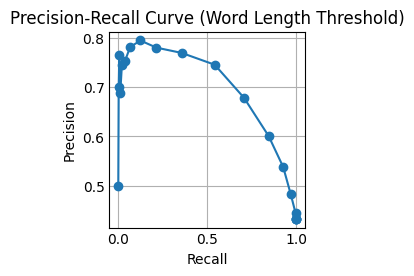

In [19]:


import matplotlib.pyplot as plt


plt.style.use('_mpl-gallery')


import matplotlib.pyplot as plt

def plot_pr_curve(train_data):
    twords, tlabels = train_data
    precisions, recalls = [], []

    for i in range(20):
        preds = length_threshold_feature(twords, i)
        prec = get_precision(tlabels, preds)
        rec = get_recall(tlabels, preds)
        precisions.append(prec)
        recalls.append(rec)

    plt.figure()
    plt.plot(recalls, precisions, marker='o')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (Word Length Threshold)")
    plt.grid(True)
    plt.show()



### 2.2: Word length thresholding
## Makes feature matrix for word_length_threshold
def length_threshold_feature(words, threshold):
    # return predictions based on the threshold
    pred = [1 if len(a) >= threshold else 0 for a in words]
    return pred
## Finds the best length threshold by f-score, and uses this threshold to
## classify the training and development set
def word_length_threshold(train_data, dev_words):
    best_score = -1
    best_length = 0

    twords, tlabels = train_data
    for i in range(20):
      length_feature = length_threshold_feature(twords, i)
      f = get_fscore(tlabels, length_feature)

      if f > best_score:
          best_score = f
          best_length = i
    print(best_length)
    ## YOUR CODE HERE
    dev_pred = []
    dev_pred = length_threshold_feature(dev_words, best_length)

    return dev_pred

plot_pr_curve(train_data)

- **Answer 2.2:** Please report the precision, recall, and f-score on both the training data and the development data.
    - Training **[writeup.pdf]**
    - Development **[writeup.pdf]**
    - Range of thresholds tested using the training data **[writeup.pdf]**
    - Best threshold **[writeup.pdf]**
    - Precision-recall Curve for training data **[writeup.pdf]**
        - For plotting, [matplotlib](https://matplotlib.org/) is a useful python library

In [20]:
dev_words, dev_labels = dev_data
y_pred = word_length_threshold(train_data, dev_words)
print(get_precision(dev_labels, y_pred))
print(get_recall(dev_labels, y_pred))
dfscore = get_fscore(dev_labels, y_pred)
print(dfscore)

dev_words, dev_labels = train_data
y_pred = word_length_threshold(train_data, dev_words)
print(get_precision(dev_labels, y_pred))
print(get_recall(dev_labels, y_pred))
dfscore = get_fscore(dev_labels, y_pred)
print(dfscore)



7
0.6053511705685619
0.8660287081339713
0.7125984251968505
7
0.6007401315789473
0.8440207972270364
0.7018976699495555


In [21]:
# PennGrader - DO NOT CHANGE

word_length_pred = word_length_threshold(train_data, mini_test_words)
grader.grade(test_case_id = 'test_baseline_q22', answer = word_length_pred)

7
Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 2.3 Word frequency baseline


Our final baseline is a classifier similar to the last one, but thresholds on word frequency instead of length. We have provided Google NGram frequencies in the text file ngram_counts.txt, along with the helper function `load_ngram_counts(ngram_counts_file)` to load them into Python as a dictionary.

You will be filling in the function `word_frequency_threshold(train_data, dev_data, ngram_counts)`, where `ngram_counts` is the dictionary of word frequencies. This function again finds the best threshold and returns predictions on the development data.

Please again report the precision, recall, and f-score on the training and development data individually, along with the range of thresholds you tried, and the best threshold to be graded. Similar to the previous baseline, plot the Precision-Recall curve for range of thresholds you tried. Compared with word length baseline, which classifier looks better on average?

**Note: Due to its size, loading the ngram counts into Python takes around 20 seconds, and finding the correct threshold may take a few minutes to run.**

- **Problem 2.3:** Implement `word_frequency_threshold()` that finds the best word frequency threshold and makes predictions on the development (or testing) data.

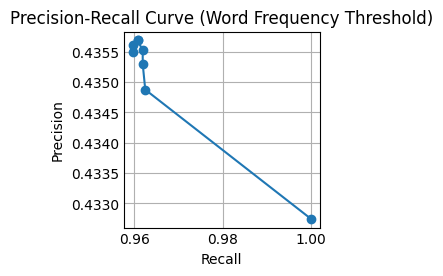

In [47]:

import matplotlib.pyplot as plt


plt.style.use('_mpl-gallery')


def plot_pr_curve(train_data):
    twords, tlabels = train_data
    precisions, recalls = [], []

    for i in range(0, 4000,500):
        preds = frequency_threshold_feature(twords, i, ngram_counts)
        prec = get_precision(tlabels, preds)
        rec = get_recall(tlabels, preds)
        precisions.append(prec)
        recalls.append(rec)

    plt.figure()
    plt.plot(recalls, precisions, marker='o')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (Word Frequency Threshold)")
    plt.grid(True)
    plt.show()






## Make feature matrix for word_frequency_threshold
def frequency_threshold_feature(words, threshold, ngram_counts):
    # return predictions based on the threshold
    # ngram_counts dictionary : {words: frequency} Think of this like a function
    pred = [1 if ngram_counts.get(word, 0) >= threshold else 0 for word in words]
    # hint: check the content of `ngram_counts` variable
    return pred
def word_frequency_threshold(train_data, dev_words, ngram_counts):
    twords, tlabels = train_data
    print(tlabels)

    final_best = -1
    f_best = 0
    final_pred = 0
    ## YOUR CODE HERE
    for i in range(4000):
      improve_pred = frequency_threshold_feature(twords, i, ngram_counts)
      f = get_fscore(tlabels, improve_pred)
      if f > f_best:
        f_best = f
        final_pred = i
    print(final_pred)



    dev_pred = frequency_threshold_feature(dev_words, final_pred, ngram_counts)
    return dev_pred


plot_pr_curve(train_data)

- **Answer 2.3:** Please report the precision, recall, and f-score on both the training data and the development data.
    - Training **[writeup.pdf]**
    - Development **[writeup.pdf]**
    - Range of thresholds tested using the training data **[writeup.pdf]**
    - Best threshold **[writeup.pdf]**
    - Precision-recall Curve for training data **[writeup.pdf]**
        - For plotting, [matplotlib](https://matplotlib.org/) is a useful python library

In [48]:
dev_words, dev_labels = dev_data
y_pred = word_frequency_threshold(train_data, dev_words, ngram_counts)
print(get_precision(dev_labels, y_pred))
print(get_recall(dev_labels, y_pred))
dfscore = get_fscore(dev_labels, y_pred)
print(dfscore)

dev_words, dev_labels = train_data
y_pred = word_frequency_threshold(train_data, dev_words,ngram_counts)
print(get_precision(dev_labels, y_pred))
print(get_recall(dev_labels, y_pred))
dfscore = get_fscore(dev_labels, y_pred)
print(dfscore)



[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 

In [49]:
# PennGrader - DO NOT CHANGE
word_freq_pred = word_frequency_threshold(train_data, mini_test_words, ngram_counts)
grader.grade(test_case_id = 'test_baseline_q23', answer = word_freq_pred)

[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 

# Section 3. Classifiers

### 3.1 Naive Bayes classification


Now, let’s move on to actual machine learning classifiers! For our first classifier, you will use the built-in [Naive Bayes model from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html), to train a classifier. You should refer to the online sklearn documentation when you are building your classifier.

The first thing to note is that sklearn classifiers take in `numpy` arrays, rather than regular lists. You may use the [online numpy documentation](https://numpy.org/doc/stable/). To create a `numpy` list of length 5, you can use the following Python commands:

```
import numpy as np
X = np.array([1,2,3,4,5])
```


To train a classifier, you need two numpy arrays: `X_train`, an `m` by `n` array, where `m` is the number of words in the dataset, and `n` is the number of features for each word; and `Y`, an array of length `m` for the labels of each of the words.

**Before we start training models, we need to convert our texts/words into numpy arrays, i.e. making training/testing feature vectors.**

- **Problem 3.0**: Implementing `get_training_features()` and `get_test_features()` that convert train/test dataset to numpy arrays

In [25]:
%%capture
# run the following cell if you want to use count of syllabus as a feature
!pip install syllables
import syllables

In [26]:



def get_training_features(train_data, ngram_counts):
    words, y_true = train_data
    print("First few words:", words[:10])
    print("First few y_true:", y_true[:10])
    features = []
    for word in words:
        ## YOUR CODE HERE
        # 1. word length feature
        word_ln = len(word)
        # 2. unigram frequency feature
        word_freq = ngram_counts.get(word, 0)
        # 3. (optional) syllables count feature
        # pass


        features.append(([word_ln, word_freq]))
    print("First few features:", features[:10])
    X = np.asarray(features)
    ## YOUR CODE HERE
    # TODO: calculate the mean and std of the vectorized data (X)
    means = np.mean(X, axis=0)
    stds = np.std(X, axis = 0)

    # def normalize_array(arr):
    # norm_arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    # return norm_ar

    # TODO: calculate the scaled data, with the mean and std you just calculated
    # X_normalized = (X - X.mean()) / X.std(ddof=1)
    for idx in range(len(stds)):
      if stds[idx] == 0:
        stds[idx] = 1
    X_scaled = (X - means)/(stds)

    # then we can cap the outliers

    Y = np.asarray(y_true)
    return X_scaled, Y, means, stds

def get_test_features(dev_words, ngram_counts, means, stds):

    ## YOUR CODE HERE
    # TODO: do the similar thing, except using means and stds as given (from training data)
    # I need the practice, so I'm going to code it again. This time with better comments to explain what I'm doing.
    features = []
    for word in dev_words:
        # 1. word length feature
        word_ln = len(word)
        # 2. unigram frequency feature
        word_freq = ngram_counts.get(word, 0)
        # 3. (optional) syllables count feature
        # pass


        features.append(([word_ln, word_freq]))


    X = np.asarray(features)

    # def normalize_array(arr):
    # norm_arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    # return norm_ar

    # TODO: calculate the scaled data, with the mean and std you just calculated
    # X_normalized = (X - X.mean()) / X.std(ddof=1)
    X_scaled = (X - means)/(stds)


    return X_scaled


In [27]:
# PennGrader - DO NOT CHANGE
dev_words, dev_labels = dev_data
X_train, Y_train, means, stds = get_training_features(train_data, ngram_counts)
X_dev = get_test_features(dev_words, ngram_counts, means, stds)

train_feats = (X_train, Y_train, means, stds)
test_feats = (X_dev)

grader.grade(test_case_id = 'test_q30_test_feature_shapes', answer = (train_feats, test_feats))

First few words: ['string', 'derailed', 'asylum-seekers', 'shaping', 'worked', 'away', 'spray', 'considers', 'wear', 'magma']
First few y_true: [0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
First few features: [[6, 20328352], [8, 268291], [14, 0], [7, 6490936], [6, 71039936], [4, 240905722], [5, 6875512], [9, 12965800], [4, 25707924], [5, 1346633]]
Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Once we have these feature arrays, we can fit a Naive Bayes classifier using the following commands:
```
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, Y)
```
Finally, to use your model to predict the labels for a set of words, you only need one numpy array: `X_test`, an `m` by `n` array, where `m` is the number of words in the test set, and `n` is the number of features for each word. Note that the `n` used here is the same as the `n` in `X_train`. Then, we can use our classifier to predict labels using the following command:

```
Y_pred = clf.predict(X_test)
```

- **Problem 3.1**: Fill in the function `naive_bayes(train_data, dev_data, ngram_counts)`. This function will train a Naive Bayes classifier on the training data using **word length** and **word frequency** as features, and returns your model’s predictions on the training data and the development data individually.
    - **NOTE**: Before training and testing a classifier, it is generally important to normalize your features. This means that you need to find the mean and standard deviation (sd) of a feature. Then, for each row, perform the following transformation: `X_scaled = (X_original - mean)/sd`. **Be sure to always use the means and standard deviations from the training data**.
    - **Optional**: You can include more features if you want to, e.g. [the count of syllabus](https://github.com/prosegrinder/python-syllables)


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [29]:
## Trains a Naive Bayes classifier using length and frequency features
def naive_bayes(train_data, dev_words, ngram_counts):
    # TODO
    # cHat = argmax c exists in C of p(c|D)
    # 1. Gets the features from the training data, and trains the model
    clf = GaussianNB()

    words, y_true = train_data
    X,Y, mean, std = get_training_features(train_data, ngram_counts)
    clf.fit(X, Y)
    train_pred = clf.predict(X)
    x_dev = get_test_features(dev_words,ngram_counts,mean,std)

    # 2. Train model & inference on dev_words
    ## YOUR CODE HERE
    dev_pred = clf.predict(x_dev)

    return train_pred, dev_pred

- **Answer 3.1:** Please report the precision, recall, and f-score on both the training data and the development data.
    - Training **[writeup.pdf]**
    - Development **[writeup.pdf]**

In [30]:
# report train/development metrics!
dev_words, dev_labels = dev_data
train_pred, dev_pred = naive_bayes(train_data, dev_words, ngram_counts)
print(get_precision(dev_labels, dev_pred))
print(get_recall(dev_labels, dev_pred))
print(get_fscore(dev_labels, dev_pred))

dev_words, dev_labels = train_data
train_pred, dev_pred = naive_bayes(train_data, dev_words, ngram_counts)
print(get_precision(dev_labels, dev_pred))
print(get_recall(dev_labels, dev_pred))
print(get_fscore(dev_labels, dev_pred))


First few words: ['string', 'derailed', 'asylum-seekers', 'shaping', 'worked', 'away', 'spray', 'considers', 'wear', 'magma']
First few y_true: [0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
First few features: [[6, 20328352], [8, 268291], [14, 0], [7, 6490936], [6, 71039936], [4, 240905722], [5, 6875512], [9, 12965800], [4, 25707924], [5, 1346633]]
0.46929316338354576
0.9688995215311005
0.6323185011709602
First few words: ['string', 'derailed', 'asylum-seekers', 'shaping', 'worked', 'away', 'spray', 'considers', 'wear', 'magma']
First few y_true: [0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
First few features: [[6, 20328352], [8, 268291], [14, 0], [7, 6490936], [6, 71039936], [4, 240905722], [5, 6875512], [9, 12965800], [4, 25707924], [5, 1346633]]
0.4950379451255108
0.9797804737146159
0.6577467519875897


In [31]:
# PennGrader - DO NOT CHANGE
train_pred, mini_test_pred = naive_bayes(train_data, mini_test_words, ngram_counts)
grader.grade(test_case_id = 'test_naive_bayes', answer = mini_test_pred)

First few words: ['string', 'derailed', 'asylum-seekers', 'shaping', 'worked', 'away', 'spray', 'considers', 'wear', 'magma']
First few y_true: [0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
First few features: [[6, 20328352], [8, 268291], [14, 0], [7, 6490936], [6, 71039936], [4, 240905722], [5, 6875512], [9, 12965800], [4, 25707924], [5, 1346633]]
Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 3.2 Logistic Regression
Next, you will use sklearn’s built-in Logistic Regression classifier. Again, we will use word length and word frequency as your two features. You should refer to [the online sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) when you are building your classifier. To import and use this model, use the following command:

```
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
```

- **Problem 3.2**: For this problem, you will be filling in the function `logistic_regression(train_data, dev_data, ngram_counts)`. This function will train a `Logistic Regression` classifier on the training data, and returns your model’s predictions on the training data and the development data individually.


In [32]:
def logistic_regression(train_data, dev_words, ngram_counts):
    #spent two hours on this arhg

    train_words, train_labels = train_data
    print(train_labels)
    clf = LogisticRegression()
    X, Y, mean, std = get_training_features(train_data, ngram_counts)
    check = np.unique(Y)
    print(check)

    clf.fit(X, Y, 1)
    train_pred = clf.predict(X)
    X_dev = get_test_features(dev_words, ngram_counts, mean, std)
    dev_pred = clf.predict(X_dev)

    return train_pred, dev_pred


- **Answer 3.2:** Please report the precision, recall, and f-score on both the training data and the development data.
    - Training **[writeup.pdf]**
    - Development **[writeup.pdf]**

In [33]:
dev_words, dev_labels = dev_data
train_pred, dev_pred = logistic_regression(train_data, dev_words, ngram_counts)
print(get_precision(dev_labels, dev_pred))
print(get_recall(dev_labels, dev_pred))
print(get_fscore(dev_labels, dev_pred))

dev_words, dev_labels = train_data
train_pred, dev_pred = logistic_regression(train_data, dev_words, ngram_counts)
print(get_precision(dev_labels, dev_pred))
print(get_recall(dev_labels, dev_pred))
print(get_fscore(dev_labels, dev_pred))

[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 

In [34]:
# PennGrader - DO NOT CHANGE
train_pred, mini_test_pred = logistic_regression(train_data, mini_test_words, ngram_counts)
grader.grade(test_case_id = 'test_logistic', answer = mini_test_pred)

[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 

## 3.3 Comparing Naive Bayes and Logistic Regression
- **Answer 3.3**: After implementing Naive Bayes and Logistic Regression classifiers, you will notice that their performance is not identical, even though they are given the same data. **Write a paragraph below that discusses which model performed better on this task and what are the potential reasons.**
    - [TODO: discussion of the differences in your writeup.pdf]

In [35]:
## Answer in your writeup.pdf

# Section 4. Build your own model
Finally, the fun part! In this section, you will build your own classifier for the complex word identification task, and compare your results to that of your classmates. You will also perform an error analysis for your best performing model.

You can choose any other types of classifier, and any additional features you can think of!
- For classifiers, beyond `Naive Bayes` and `Logistic Regression`, you might consider trying `SVM`, `Decision Trees`, and `Random Forests`, among others.
- Additional word features that you might consider include number of syllables, number of `WordNet` synonyms, and number of `WordNet` senses. To use WordNet in Python, refer to [this documentation](http://www.nltk.org/howto/wordnet.html).
- You could also include sentence-based complexity features, such as length of the sentence, average word length, and average word frequency.

When trying different classifiers, we recommend that you train on training data, and test on the development data, like the previous sections.

In the following cell, please include a description of **all of the models** and **features** that you tried. To receive full credit, you MUST try **at least 1 type of classifier** (not including `Naive Bayes` and `Logistic Regression`), and **at least two features** (not including length and frequency).

**Note**: You can also tune the parameters of your model, e.g. what type of kernel to use. This is NOT required, as some of you may not be that familiar with this.



## 4.1 Your Own Model

An important part of text classification tasks is to determine what your model is getting correct, and what your model is getting wrong. For this problem, you must train your best model on the training data, and report the precision, recall, and f-score on the development data. In order to receive full credit, your model must be able to outperform all of the baselines.

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


6.10225


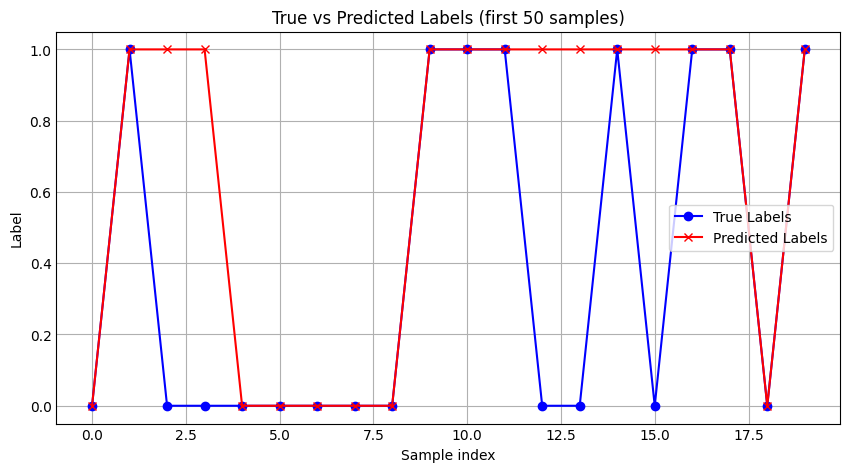

(array([0, 0, 1, ..., 0, 0, 0]), array([0, 1, 1, ..., 1, 1, 0]))

In [36]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4') # Optional: for multilingual WordNet support
from nltk.corpus import wordnet as wn
from sklearn.metrics import confusion_matrix
import seaborn as sns

# I've decided to use synonyms. Often times simple words have the most synonyms. Perhaps this isn't always true, but as the words become more verbose, they become more specific, and the number the synonyms tends to decrease.
# I think this is a fair metric to test on without embarking on a full research project.
# I used the NB classifier. Although it was hard to estimate considering the train_labels all had 1 as their answer.

def word_net_model(train_data, test_words, ngram_counts):

  #dataset and variable declaration/init
  train_words, train_labels = train_data
  train_dataset = []
  dataset_total = []
  feature_training = []
  testword_dataset = []
  final_best = -1
  score_1 = 0
  final_pred = 0

  ## creating the optimal synonym length feature, this is actually pretty cool!
  syn_counts = [len(wn.synonyms(word)) for word in train_words]
  avg_synonyms = np.mean(syn_counts)
  print(avg_synonyms)
  for word in train_words:
    #if the number of synonyms exceed avg 6, then it's simple!
    if len(wn.synonyms(word)) < avg_synonyms:
      feature_training.append(1)
    else:
      feature_training.append(0)

  #creating the X array for the train_words
  for word in train_words:
        ## YOUR CODE HERE
        # 1. word length feature
        word_ln = len(wn.synonyms(word))
        # 2. unigram frequency feature
        word_freq = ngram_counts.get(word, 0)
        #populating the dataset
        train_dataset.append(([word_ln, word_freq]))
  #creating the X array for the test_words
  for word in test_words:
        ## YOUR CODE HERE
        # 1. word length feature
        word_ln = len(wn.synonyms(word))
        # 2. unigram frequency feature
        word_freq = ngram_counts.get(word, 0)
        # 3. (optional) syllables count feature
        # pass
        testword_dataset.append(([word_ln, word_freq]))

  #Creating datastructure for statistical analysis
  X = np.asarray(train_dataset)
  X_2 = np.asarray(testword_dataset)


  #Calculating statistics
  means = np.mean(X, axis=0)
  stds = np.std(X, axis = 0)
  #means/std
  means_test = np.mean(X_2, axis=0)
  stds_test = np.std(X_2, axis = 0)

  #gaussian NB calculations
  X_scaled = (X - means)/(stds)
  X2_scaled = (X-means)/(stds)
  Y = np.asarray(train_labels)
  clf = GaussianNB()
  clf.fit(X_scaled, Y)
  train_pred = clf.predict(X)
  clf.fit(X2_scaled, Y)
  test_pred = clf.predict(X2_scaled)

  #Using true versus predicted analysis
  plt.figure(figsize=(8, 4))
  plt.plot(train_labels[:20], 'bo-', label="True Labels")   # first 50 for clarity
  plt.plot(feature_training[:20], 'rx-', label="Predicted Labels")
  plt.legend()
  plt.title("True vs Predicted Labels (first 50 samples)")
  plt.xlabel("Sample index")
  plt.ylabel("Label")
  plt.show()

  #reporting data
  precision = get_precision(train_labels, feature_training)
  recall = get_recall(train_labels, feature_training)
  f_score = get_fscore(train_labels, feature_training)

  return train_pred, test_pred

word_net_model(train_data, test_words, ngram_counts)
  # print(precision, recall, f_score)
  # print(feature)
  # print(dataset_array)





- **Answer 4.1**: Train your best model on the training data, and report the precision, recall, and f-score on the development data

6.10225


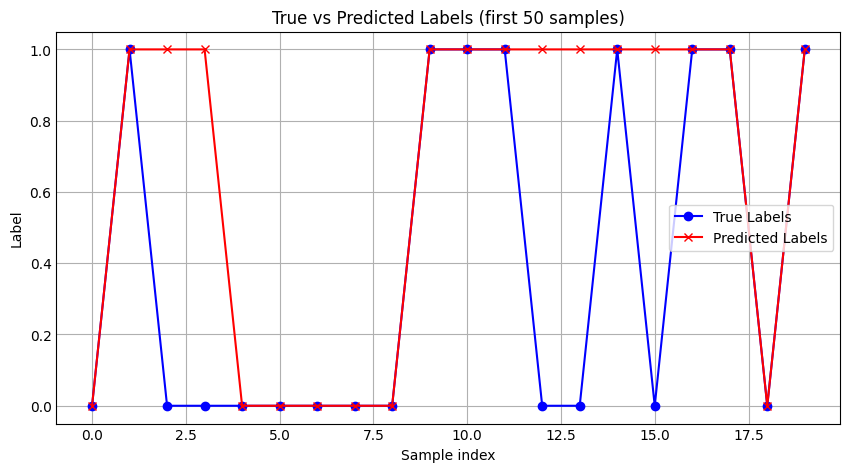

0.1084672435105068
0.8397129186602871
0.19211822660098518
6.10225


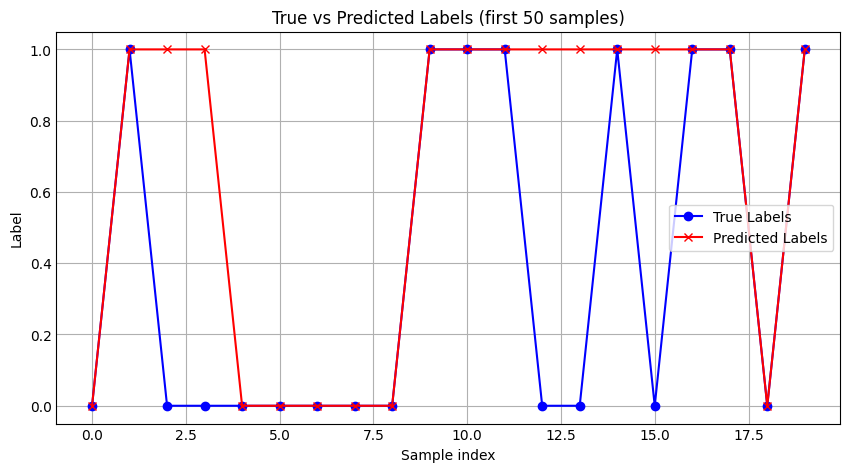

0.5139060568603214
0.9607163489312536
0.6696194886249245


In [37]:
dev_words, dev_labels = dev_data
train_pred, dev_pred = word_net_model(train_data, dev_words, ngram_counts)
print(get_precision(dev_labels, dev_pred))
print(get_recall(dev_labels, dev_pred))
print(get_fscore(dev_labels, dev_pred))

dev_words, dev_labels = train_data
train_pred, dev_pred = word_net_model(train_data, dev_words, ngram_counts)
print(get_precision(dev_labels, dev_pred))
print(get_recall(dev_labels, dev_pred))
print(get_fscore(dev_labels, dev_pred))

## 4.2 Analyze your model


Describe the model and features you choose, and perform a detailed error analysis of your models. Give several examples of words on which your best model performs well. Also give examples of words which your best model performs poorly on, and identify at least TWO categories of words on which your model is making errors.




- **Answer 4.2**: Write a detailed description of your model and features used. Also include error analysis of your model.

In [38]:
## Answer in your writeup.pdf

## 4.3 Leaderboard
Finally, use your classifier to predict labels for the test data, and submit these labels in a text file named `test_labels.txt` (with one label per line) to the leaderboard; be sure NOT to shuffle the order of the test examples. Instructions for how to post to the leaderboard will be posted on Ed soon.
**In addition, the top 3 submissions will receive 5 bonus points! A successful submission to the leaderboard will guarantee 2 points!**

In [39]:
from google.colab import drive
drive.mount('/content/drive')


output_path = "/content/drive/My Drive/Colab Notebooks/test_labels.txt"
train_pred, test_pred = word_net_model(test_set, test_words, ngram_counts)
with open(output_path, 'w') as f:
    f.write("\n".join(map(str, test_pred)))


    print('confirm')
!pwd

Mounted at /content/drive


NameError: name 'test_set' is not defined

- **Results 4.3**: Upload your `test_labels.txt` to the leaderboard in Gradescope.

## 4.4. (Optional) Leaderboard using outside data

While the training data we have provided is sufficient for completing this assignment, it is not the only data for the task of identifying complex words. As an optional addition to this homework, you may look for and use any additional training data, and submit your predicted labels in a text file named `test_labels.txt` to the leaderboard.

As a start, we recommend looking at the [SemEval 2016 dataset](http://alt.qcri.org/semeval2016/task11/), a dataset that was used in a complex words identification competition. In addition, you can try to use data from [Newsela](https://newsela.com/). Newsela’s editors re-write newspaper articles to be appropriate for students at different grade levels. The company has generously shared a dataset with us. The Newsela data **may not** be re-distributed outside of Penn. You can find the data on eniac at `/home1/c/ccb/data/newsela/newsela_article_corpus_with_scripts_2016-01-29.1.zip`.

Good luck, and have fun!

# Submission
Here are the deliverables you need to submit to GradeScope:
- Write-up:
    - Answers to all questions labeled as `Answer #.#` in a file named `writeup.pdf`
- Code:
    - This notebook and py file: rename to `homework2.ipynb` and `homework2.py`. You can download the notebook and py file by going to the top-left corner of this webpage, `File -> Download -> Download .ipynb/.py`
- Leaderboard Results:
  - Your model’s output for the test set using only the provided training and development data (`test_labels.txt`)
  - (Optional) your model’s output for the test set, using any data that you want. (`test_labels.txt`)